<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="680" height="140" align="right"/>

<h4 style="text-align: center;">Curso: Proyecto de grado 2</h4>
<h4 style="text-align: center;">Tarea: Fase 1</h4>
<h4 style="text-align: center;">Presentado por: Oscar Andrés Russi Porras</h4>
<h4 style="text-align: center;">Universidad Nacional Abierta y a Distancia – UNAD</h4>
<h4 style="text-align: center;">Fecha: Abril de 2025</h4>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import datetime
from IPython.display import display
from sklearn.decomposition import PCA

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import random
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree

## Conectar datos

In [4]:
import urllib
from sqlalchemy import create_engine
import pandas as pd
columns_to_check = ['price', 'habitaciones', 'banyos', 'estrato', 'areaConstruida',
                        'areaPrivada', 'parqueaderos', 'administracion', 'pisoNumero', 'totalPisos']

params = urllib.parse.quote_plus(
    "DRIVER={SQL Server};"
    "SERVER=DESKTOP-KNKLQ23\MSSQLSERVER01;DATABASE=inmuebles;"
    "UID=oscarrussi;PWD=a1s2d3f4;"
)

# "mssql+pyodbc" es el dialecto para SQL Server a través de pyodbc
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

In [5]:
query = "select * from dbo.datosVivienda where (price is not null and price<>'') and (ubicacion is not null and ubicacion<>'')"
df = pd.read_sql(query, engine)

print(df.head())

            price  habitaciones  \
0    120000000.00          2.00   
1    105000000.00          1.00   
2   7850000000.00          1.00   
3  22000000000.00          1.00   
4 107158800000.00           NaN   

                                              descr  \
0                              Apartamento en venta   
1              Edificio en venta, Bogotá - Germania   
2  Edificio en venta, Bogotá - Primavera Occidental   
3                                   Bodega en venta   
4                                     Lote en venta   

                                                link  banyos       id  \
0  https://www.fincaraiz.com.co/apartamento-en-ve...    1.00  2351795   
1  https://www.fincaraiz.com.co/edificio-en-venta...     NaN  3056432   
2  https://www.fincaraiz.com.co/edificio-en-venta...    2.00  3072117   
3  https://www.fincaraiz.com.co/bodega-en-venta/3...     NaN  3129789   
4  https://www.fincaraiz.com.co/lote-en-venta/314...     NaN  3149801   

  tipoInmueble   es

# Exploración preliminar

## Caracterización general de la muestra 

In [6]:
pd.set_option('display.float_format', '{:.2f}'.format)
main_columns=["price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion","pisoNumero","totalPisos"]
summary = df[main_columns]
summary_statistics = summary.describe(include='all')

# Display summary statistics
summary_statistics

,price,habitaciones,banyos,estrato,areaConstruida,areaPrivada,parqueaderos,administracion,pisoNumero,totalPisos
count,11333.00,10258.00,10591.00,11190.00,11248.00,10268.00,7362.00,6598.00,8613.00,8026.00
mean,20236320845.38,2.86,2.61,4.06,152.60,123.97,2.42,2841822.32,3.54,1.34
std,907774346842.56,4.53,2.04,1.33,174.63,170.31,3.47,42955543.09,4.09,2.94
min,1000.00,0.00,0.00,1.00,0.00,0.00,-1.00,0.00,0.00,0.00
25%,259999980.00,2.00,1.00,3.00,52.00,31.00,1.00,150000.00,0.00,0.00
50%,495000000.00,3.00,2.00,4.00,83.00,65.00,2.00,342000.00,2.00,0.00
75%,1170000000.00,3.00,3.00,5.00,178.25,140.00,2.00,749500.00,5.00,1.00
max,95000000000000.00,400.00,60.00,7.00,998.00,998.00,127.00,2000000000.00,21.00,21.00


## Calidad de la información

In [22]:
def discrete_variable_summary(df):
    summaries = []
    excluir = ['comodidades', 'date_created', 'date_modified']
    df_resultado = df.drop(columns=excluir)
    
    total = df.shape[0]  # total de registros incluyendo nulos
    
    for column in df_resultado.columns.tolist():
        # Moda sin nulos
        moda = df[column].mode(dropna=True)[0]
        freq = df[df[column] == moda].shape[0]
        total_no_nulos = df[column].count()
        perc = (freq / total_no_nulos) * 100 if total_no_nulos > 0 else 0

        # Nulos
        nulos = df[column].isna().sum()
        
        # Moda considerando nulos
        if nulos > freq:
            moda_nulos = np.nan
            freq_nulos = nulos
        else:
            moda_nulos = moda
            freq_nulos = freq
        
        perc_nulos = (freq_nulos / total) * 100 if total > 0 else 0

        summary = {
            'col': column,
            'uniques': df[column].nunique(),
            'mode': moda,
            'freq': freq,
            'perc': round(perc, 2),
            'mode_nulos': moda_nulos,
            'freq_nulos': freq_nulos,
            'perc_nulos': round(perc_nulos, 2)
        }
        summaries.append(summary)

    return pd.DataFrame(summaries)


discrete_variable_summary(df)

,col,uniques,mode,freq,perc,mode_nulos,freq_nulos,perc_nulos
0,price,1830,350000000.00,125,1.10,350000000.00,125,1.10
1,habitaciones,29,3.00,4352,42.43,3.00,4352,38.40
2,descr,933,Apartamento en Venta,5138,45.34,Apartamento en Venta,5138,45.34
3,link,11333,https://www.fincaraiz.com.co/apartaestudio-en-...,1,0.01,https://www.fincaraiz.com.co/apartaestudio-en-...,1,0.01
4,banyos,24,2.00,3831,36.17,2.00,3831,33.80
5,id,11333,2351795,1,0.01,2351795,1,0.01
6,tipoInmueble,15,Apartamento,6930,61.26,Apartamento,6930,61.15
7,estadoInmueble,6,¡Pregúntale!,10431,92.20,¡Pregúntale!,10431,92.04
8,areaConstruida,1218,60.00,156,1.39,60.00,156,1.38
9,areaPrivada,1076,0.00,1816,17.69,0.00,1816,16.02


## Distribución de los datos

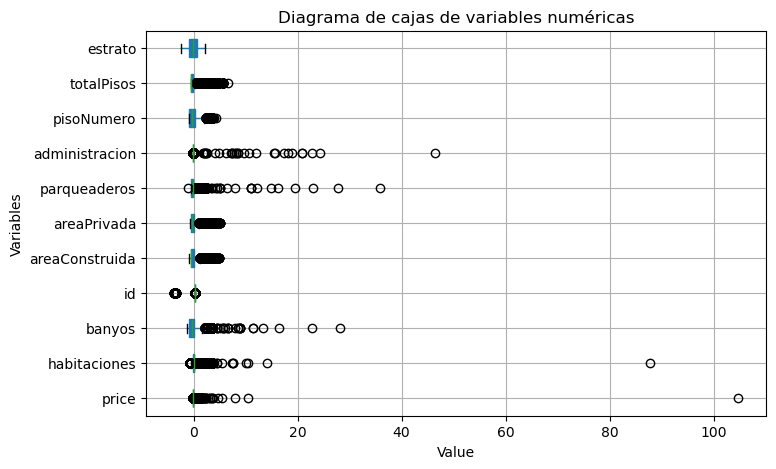

In [23]:
def clasificar_variable(tipo):
    if pd.api.types.is_numeric_dtype(tipo):
        return 'Numérica'
    elif pd.api.types.is_string_dtype(tipo):
        return 'Categórica'
    else:
        return 'Otra'



def create_box(df_):
    numerics = [num for num in df_.columns if clasificar_variable(df_[num].dtype)=='Numérica']
    scaler = StandardScaler()
    # Create a copy of the DataFrame and normalize the selected columns
    df_normalized = df_[numerics].copy()
    df_normalized[numerics] = scaler.fit_transform(df_[numerics])
    # Create the horizontal boxplot
    plt.figure(figsize=(8, 5))
    df_normalized.boxplot(vert=False, patch_artist=True)
    # Set the title, labels, and y-ticks
    plt.title('Diagrama de cajas de variables numéricas')
    plt.xlabel('Value')
    plt.ylabel('Variables')
    plt.yticks(ticks=range(1, len(numerics) + 1), labels=numerics)  # Set labels based on column names
    plt.grid(True)
    plt.show()

create_box(df)

## Relaciones entre variables numéricas

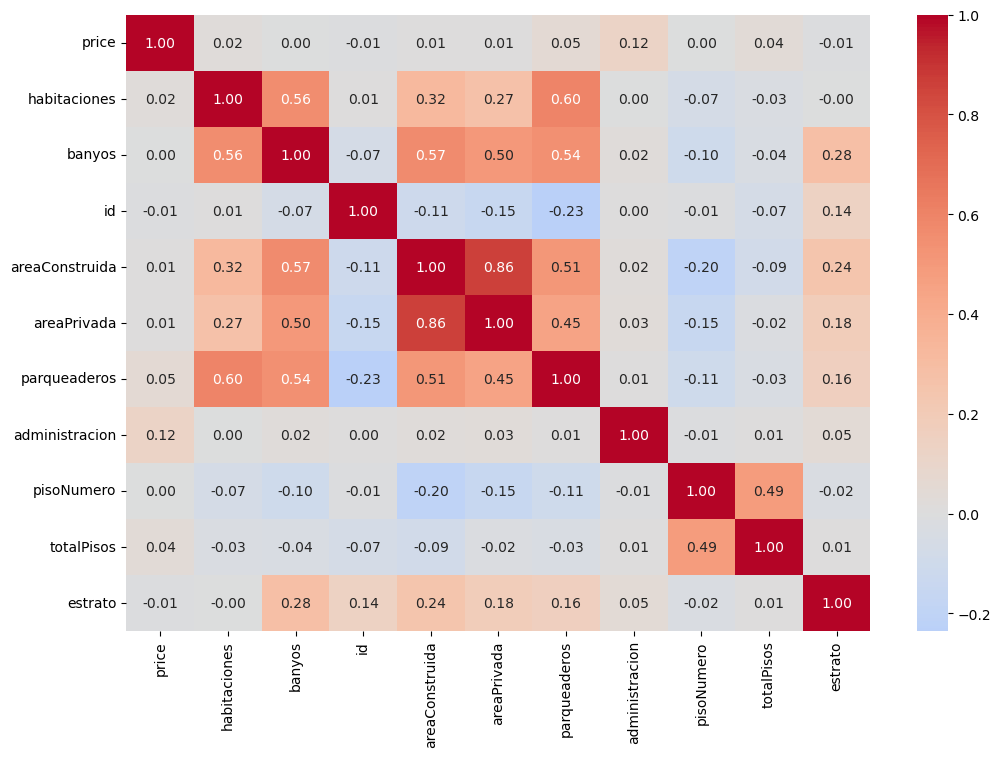

In [26]:
numerics = [num for num in df.columns if clasificar_variable(df[num].dtype)=='Numérica']

def corr_matrix(df_):
    # Assuming df_hotels_booking is your DataFrame and 'numerics' is a list of numeric columns
    correlation_matrix = df_[numerics].corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.show()  # display the heatmap

corr_matrix(df)

# Limpieza de datos

In [27]:
trash_columns = ['descr', 'link','id']
df_nuevo = df.drop(columns=trash_columns)
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11333 entries, 0 to 11332
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   price           11333 non-null  float64       
 1   habitaciones    10258 non-null  float64       
 2   banyos          10591 non-null  float64       
 3   tipoInmueble    11313 non-null  object        
 4   estadoInmueble  11313 non-null  object        
 5   areaConstruida  11248 non-null  float64       
 6   areaPrivada     10268 non-null  float64       
 7   antiguedad      11333 non-null  object        
 8   parqueaderos    7362 non-null   float64       
 9   administracion  6598 non-null   float64       
 10  pisoNumero      8613 non-null   float64       
 11  totalPisos      8026 non-null   float64       
 12  comodidades     9616 non-null   object        
 13  ubicacion       11333 non-null  object        
 14  estrato         11190 non-null  float64       
 15  da

In [28]:
print(f"records before cleaning dataframe: {df_nuevo.count()}")
def clean_dataframe(df_):
    # Remove rows with negative values, ignoring NaNs
    for col in columns_to_check:
        df_ = df_[(df_[col] >= 0) | (df_[col].isnull())]

    print(f"Total rows after removing negatives: {df_.shape[0]}")

    # Remove rows where 'estrato' is greater than 6, ignoring NaNs
    df_ = df_[(df_['estrato'] <= 6) | (df_['estrato'].isnull())]

    df_['estadoInmueble'] = df_['estadoInmueble'].replace('¡Pregúntale!', np.nan)
    # Reset the DataFrame index
    df_.reset_index(drop=True, inplace=True)

    return df_

df_cleaned=clean_dataframe(df_nuevo)
print(f"records after cleaning dataframe: {df_cleaned.count()}")

records before cleaning dataframe: price             11333
habitaciones      10258
banyos            10591
tipoInmueble      11313
estadoInmueble    11313
areaConstruida    11248
areaPrivada       10268
antiguedad        11333
parqueaderos       7362
administracion     6598
pisoNumero         8613
totalPisos         8026
comodidades        9616
ubicacion         11333
estrato           11190
date_created       7006
date_modified     10489
dtype: int64
Total rows after removing negatives: 11332
records after cleaning dataframe: price             11326
habitaciones      10255
banyos            10588
tipoInmueble      11306
estadoInmueble      882
areaConstruida    11242
areaPrivada       10265
antiguedad        11326
parqueaderos       7360
administracion     6598
pisoNumero         8611
totalPisos         8024
comodidades        9613
ubicacion         11326
estrato           11183
date_created       7004
date_modified     10482
dtype: int64


In [29]:
import numpy as np
import pandas as pd

def iqr_skew_adjusted_bounds(series,  factor=3.0):
    """
    Returns (lower_bound, upper_bound) for outlier detection
    using an IQR-based rule adjusted by a log-skew factor:
    
    lower_bound = Q1 - factor * IQR * (1 / log_skew_factor)
    upper_bound = Q3 + factor * IQR * log_skew_factor
    
    The log_skew_factor = log((mean * e) / median).
    """
    valid = series.dropna()
    if valid.empty:
        return -np.inf, np.inf  # no valid data
    
    Q1 = valid.quantile(0.25)
    Q3 = valid.quantile(0.75)
    IQR = Q3 - Q1
    
    mean_val = valid.mean()
    median_val = valid.median()

    # If median is zero or negative, or mean is NaN, fallback to standard IQR
    if median_val <= 0 or np.isnan(mean_val):
        return (Q1 - factor * IQR, Q3 + factor * IQR)
    
    # Compute the log-skew factor:
    # This equals 1 when mean == median (after factoring in e)
    log_skew_factor =(mean_val / median_val)**0.68 # 1 #   np.log(mean_val * np.e / median_val) # 
    print(f"Column: {series.name}, log skew factor: {log_skew_factor:.3f}, "
          f"mean: {mean_val:.1f}, median: {median_val:.1f}, IQR: {IQR:.3f}, Q1: {Q1:.3f}, Q3: {Q3:.3f}")

    # Adjust bounds
    subs_left= factor * IQR * (1 / log_skew_factor) if log_skew_factor != 0 else factor * IQR
    add_right= factor * IQR *  log_skew_factor
    lower_bound = Q1 - subs_left
    upper_bound = Q3 + add_right
    print(f"column: {series.name}, lower bound is {lower_bound}, and upper_bound is {upper_bound:.3f}, subs left: {subs_left:.3f}, add right: {add_right:.3f}")
    return lower_bound, upper_bound

def remove_outliers_iqr_skew_all(df, factor=3.0):
    """
    Applies the iqr_skew_adjusted_bounds to each numeric column in df.
    A row is removed if it is an outlier in ANY numeric column.
    Returns a new DataFrame with those rows removed.
    """
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Start with a mask of all True
    mask = pd.Series(True, index=df.index)
    
    # For each numeric column, compute skew-adjusted IQR bounds, then refine the mask
    for col in numeric_cols:
        lb, ub = iqr_skew_adjusted_bounds(df[col], factor=factor)
        
        # Keep rows that are NaN or within [lb, ub]
        col_mask = df[col].isna() | ((df[col] >= lb) & (df[col] <= ub))
        mask &= col_mask  # logical AND: row must be non-outlier in ALL numeric cols
    
    # Return filtered DataFrame
    return df[mask].reset_index(drop=True)

df_no_outliers = remove_outliers_iqr_skew_all(df_cleaned, factor=3.5)

Column: price, log skew factor: 12.464, mean: 20224416046.3, median: 495000000.0, IQR: 910000000.000, Q1: 260000000.000, Q3: 1170000000.000
column: price, lower bound is 4467997.584155679, and upper_bound is 40868452264.666, subs left: 255532002.416, add right: 39698452264.666
Column: habitaciones, log skew factor: 0.969, mean: 2.9, median: 3.0, IQR: 1.000, Q1: 2.000, Q3: 3.000
column: habitaciones, lower bound is -1.6117842046015758, and upper_bound is 6.392, subs left: 3.612, add right: 3.392
Column: banyos, log skew factor: 1.199, mean: 2.6, median: 2.0, IQR: 2.000, Q1: 1.000, Q3: 3.000
column: banyos, lower bound is -4.837736172979896, and upper_bound is 11.394, subs left: 5.838, add right: 8.394
Column: areaConstruida, log skew factor: 1.513, mean: 152.6, median: 83.0, IQR: 126.750, Q1: 52.000, Q3: 178.750
column: areaConstruida, lower bound is -241.16378803692885, and upper_bound is 850.058, subs left: 293.164, add right: 671.308
Column: areaPrivada, log skew factor: 1.551, mean:

# Análisis descriptivo post-limpieza

## Caracterización general de la muestra

In [30]:
summary = df_no_outliers[main_columns]
summary_statistics = summary.describe(include='all')

# Display summary statistics
summary_statistics

,price,habitaciones,banyos,estrato,areaConstruida,areaPrivada,parqueaderos,administracion,pisoNumero,totalPisos
count,9183.00,8473.00,8618.00,9078.00,9134.00,8428.00,5762.00,5597.00,7199.00,6628.00
mean,1217995939.80,2.53,2.30,4.03,121.58,93.30,1.73,551254.31,3.11,0.45
std,3076177637.62,1.18,1.32,1.32,122.37,113.92,0.94,659754.71,3.82,1.07
min,4500000.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
25%,242700000.00,2.00,1.00,3.00,50.00,24.00,1.00,141000.00,0.00,0.00
50%,445000000.00,3.00,2.00,4.00,76.00,60.00,1.00,330000.00,2.00,0.00
75%,890000000.00,3.00,3.00,5.00,146.00,115.00,2.00,729000.00,4.00,0.00
max,40000000000.00,6.00,10.00,6.00,848.00,730.00,5.00,7500000.00,20.00,4.00


* La mayoría de los inmuebles registrados corresponden a apartamentos con entre 2 y 3 habitaciones y 2 baños, configuraciones que reflejan un mercado dirigido principalmente a viviendas familiares o de gama media, en línea con la estructura típica del mercado inmobiliario de Bogotá.
* 	Las variables físicas, como habitaciones, baños y parqueaderos, tienden a concentrarse en valores bajos o medios, siendo comunes los inmuebles con 1 parqueadero y ubicados en edificios de hasta 2 pisos
* Á	áreaConstruida y áreaPrivada mantienen una relación directa y elevada, lo cual es consistente con la naturaleza propia de estas variables, donde el área privada constituye una proporción significativa del área construid
* L• La variable estrato presenta una moda en el valor 3 y seis categorías distintas, lo que concuerda con la segmentación oficial de estratos socioeconómicos en Bogotá y su distribución en la oferta inmobiliaria de la ciudd.


## Calidad de la información

In [31]:
discrete_variable_summary(df_no_outliers)

,col,uniques,mode,freq,perc,mode_nulos,freq_nulos,perc_nulos
0,price,1442,350000000.00,114,1.24,350000000.00,114,1.24
1,habitaciones,7,3.00,3766,44.45,3.00,3766,41.01
2,banyos,11,2.00,3286,38.13,2.00,3286,35.78
3,tipoInmueble,15,Apartamento,5863,63.99,Apartamento,5863,63.85
4,estadoInmueble,4,Excelenteestado,370,53.39,NaN,8490,92.45
5,areaConstruida,945,50.00,141,1.54,50.00,141,1.54
6,areaPrivada,817,0.00,1642,19.48,0.00,1642,17.88
7,antiguedad,7,16 a 30 años,2723,29.65,16 a 30 años,2723,29.65
8,parqueaderos,5,1.00,2914,50.57,NaN,3421,37.25
9,administracion,1498,0.00,526,9.40,NaN,3586,39.05


* La variable estadoInmueble presenta cerca del 90% de registros sin información, luego de sustituir el placeholder ¡Pregúntale! por valores nulos. Esto sugiere que es una característica que frecuentemente no es diligenciada durante el registro de los inmuebles.
* 	Variables como areaPrivada y administracion muestran que, al incluir los nulos, estos se convierten en la moda, evidenciando una falta sistemática de información o baja prioridad en su registro
* •	Otras variables, como parqueaderos y pisoNumero, también presentan porcentajes considerables de valores nulos, posiblemente asociados a características no siempre presentes o consideradas en ciertos tipos de inmueble.


## Distribución de los datos

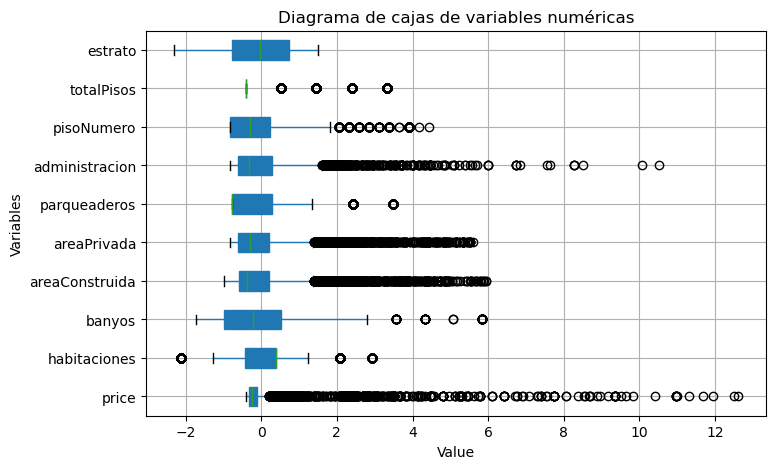

In [32]:
create_box(df_no_outliers)

* Variables como administración, áreaConstruida, áreaPrivada y price presentan numerosos valores atípicos, lo que sugiere una alta variabilidad en estas características y posibles registros con errores o inmuebles significativamente diferentes al promedio.
* Por el contrario, variables como estrato, totalPisos, baños, habitaciones y parqueaderos muestran distribuciones relativamente simétricas, lo que refleja consistencia en los datos recopilados. Sin embargo, variables como administración, áreaConstruida, áreaPrivada y, especialmente, price, exhiben una mayor dispersión, indicando una oferta diversa en cuanto a características físicas y precios de los inmuebles.

## Principales hallazgos de correlación

In [33]:
corr_matrix(df_no_outliers)

KeyError: "['id'] not in index"

* Se observa una correlación fuerte entre administracion, areaConstruida, parqueaderos y baños con price, lo que sugiere que las dimensiones y equipamiento físico de las propiedades tienen un impacto significativo en su valor.
* 	Aunque estrato muestra una relación moderada con la cuota de administración y algunas características físicas como el número de baños, su relación directa con el precio es débil. Este comportamiento es consistente con la dinámica inmobiliaria de Bogotá, donde es común encontrar inmuebles de alto valor tanto en estratos medios como en estratos altos, debido a la influencia de factores como ubicación, estado de conservación o características adicionales
* •	Finalmente, variables como pisoNumero, totalPisos y habitaciones presentan una influencia reducida sobre el precio, indicando que no son determinantes relevantes en la variabilidad del valor de los inmuebles en la muestra analizad.


## Visualización exploratoria de las variables

In [ ]:
# Suponiendo que tu dataframe se llama df y tiene la columna 'estrato'
# Contar la cantidad de inmuebles por estrato


def bar_plot(df_,variable):
    # Crear el barplot
    conteo_estrato = df_[variable].value_counts().sort_index()
    plt.figure(figsize=(8,5))
    sns.barplot(x=conteo_estrato.index, y=conteo_estrato.values)
    # Etiquetas y título
    plt.xlabel(variable)
    plt.ylabel('Número de inmuebles')
    plt.title(f'Distribución de inmuebles por {variable}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Mostrar gráfico
    plt.show()

bar_plot(df_no_outliers, "estrato")

En la Figura se presenta la distribución de inmuebles según el estrato socioeconómico. Se observa que la mayor concentración de inmuebles corresponde al estrato 3, seguido por los estratos 4 y 6. Esto refleja una predominancia de la oferta inmobiliaria en estratos medios, lo cual es consistente con la estructura socioeconómica y la dinámica urbana de Bogotá. Por otro lado, los inmuebles de estrato 1 representan una proporción significativamente menor dentro de la muestra analizada.

In [ ]:
bar_plot(df_no_outliers, "tipoInmueble")

La Figura muestra la distribución de inmuebles según el tipo de inmueble. Se evidencia una clara predominancia de apartamentos, representando la categoría con mayor cantidad de registros. Este comportamiento es consistente con el perfil urbano de la ciudad, donde los apartamentos constituyen una de las opciones habitacionales más comunes. Otros tipos de inmuebles como casas, oficinas y locales presentan una frecuencia mucho menor, mientras que categorías como consultorios, casas campestres, o lotes tienen una representación residual en la muestra. Esta distribución confirma que la oferta inmobiliaria en Bogotá está mayoritariamente orientada hacia el mercado residencial multifamiliar.

In [ ]:
bar_plot(df_no_outliers, "antiguedad")

* En la Figura se presenta la distribución de inmuebles según su antigüedad. Se observa que la mayoría de los inmuebles tienen entre 16 y 30 años de construcción, seguidos por aquellos con más de 30 años y por inmuebles de entre 9 a 15 años. Este comportamiento es coherente con el desarrollo urbano de Bogotá, donde muchas edificaciones fueron construidas durante el auge de crecimiento inmobiliario de finales del siglo XX y principios del XXI.* 
También se evidencia que las viviendas de menos de 1 año representan una proporción pequeña, indicando una menor cantidad de proyectos recientes en la muestra recopilada. Por otro lado, una cantidad significativa de registros contiene la etiqueta ¡Pregúntale!, la cual se identifica como un placeholder, lo que revela que la antigüedad de algunos inmuebles no fue diligenciada en la fuente de datos.


In [ ]:
def scatter_plot(df, col_x, col_y):
    """
    Genera un scatter plot entre dos columnas de un dataframe.

    Parámetros:
    - df: dataframe que contiene los datos
    - col_x: nombre de la columna para el eje X (string)
    - col_y: nombre de la columna para el eje Y (string)
    """
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df, x=col_x, y=col_y, alpha=0.6, edgecolor=None)

    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.title(f"Relación entre {col_x} y {col_y}")
    plt.tight_layout()
    plt.show()

scatter_plot(df_no_outliers,"price","administracion")


* En la Figura se observa la relación entre el precio de los inmuebles y el valor de la cuota de administración. Se evidencia una relación positiva entre ambas variables, donde en general, inmuebles con precios más altos tienden a asociarse con cuotas de administración más elevadas. No obstante, la dispersión es significativa, especialmente en rangos intermedios, lo que sugiere que inmuebles de precios similares pueden tener costos de administración muy variables, posiblemente debido a diferencias en servicios, ubicación o tipo de propiedad.* 
También se identifican algunos valores extremos, tanto en precios como en administración, que podrían representar inmuebles atípicos o errores de captura. Esta relación positiva es consistente con la correlación numérica previamente observada y respalda la hipótesis de que las características físicas y de servicios de los inmuebles inciden en su precio de venta


In [ ]:
scatter_plot(df_no_outliers,"administracion","estrato")

En la Figura se presenta la relación entre el valor de la cuota de administración y el estrato socioeconómico de los inmuebles. Se observa una clara tendencia en la que los inmuebles de estratos altos (especialmente 5 y 6) concentran las cuotas de administración más elevadas, mientras que en los estratos bajos (1 y 2) las cuotas de administración son considerablemente menores. Esta relación es consistente con las dinámicas típicas del mercado inmobiliario de Bogotá, donde las propiedades de estratos superiores suelen ofrecer más y mejores servicios comunales, lo que incrementa los costos asociados. 
No obstante, también se identifican algunos valores atípicos, como inmuebles de estratos bajos con cuotas de administración elevadas, lo que podría atribuirse a errores de registro o casos excepcionales como edificaciones con servicios premium ubicadas en sectores tradicionales. Esta visualización refuerza la correlación positiva previamente identificada entre estrato y administracion


In [ ]:
scatter_plot(df_no_outliers,"estrato","price")

En la Figura se muestra la relación entre el estrato socioeconómico y el precio de los inmuebles. Si bien podría esperarse una relación creciente entre ambos, la gráfica revela que no existe una asociación fuerte o lineal entre estrato y precio. Se observa una alta dispersión de precios en todos los estratos, incluyendo inmuebles de precios elevados incluso en estratos medios (3 y 4), lo que sugiere que el estrato por sí solo no es un factor determinante del precio.
Este comportamiento es consistente con la dinámica inmobiliaria de Bogotá, donde existen zonas de estrato medio con inmuebles de alto valor debido a su ubicación estratégica, tipo de inmueble o características particulares. Asimismo, en estratos altos es posible encontrar inmuebles de menor precio debido a factores como tamaño, estado de conservación o antigüedad. Esta visualización refuerza lo observado en la matriz de correlación, donde la relación entre estrato y precio resultó ser baja


In [ ]:
mapa_antiguedad = {
    "menor a 1 año": 1,
    "1 a 8 años": 2,
    "9 a 15 años": 3,
    "16 a 30 años": 4,
    "más de 30 años": 5,
    "¡Pregúntale!": np.nan  # por ejemplo, puedes marcarlo como NaN
}

df_nuevo["antiguedad"] = df_nuevo["antiguedad"].replace(mapa_antiguedad)
df_nuevo.sample(5)

dummy_columns =["tipoInmueble", "estadoInmueble", "ubicacion"]
df_encoded = pd.get_dummies(
    df_normalized,
    columns=dummy_columns
    #,drop_first=True  # This will drop the first category, preventing unnecessary columns
)

df_encoded.columns

In [ ]:
# Reemplazar NaN con cadena vacía para evitar problemas
df_no_outliers['comodidades'] = df_no_outliers['comodidades'].fillna('')

# Generar las columnas de comodidades (multi-hot encoding)
df_comodidades = df_no_outliers['comodidades'].str.get_dummies(sep='•')

# Unir al DataFrame original
df_final = df_no_outliers.join(df_comodidades)
df_final = df_final.drop(columns=["comodidades"])
df_final.columns

In [34]:
# función para generar escalado usando standard scaler
def generate_standard_scaled(df_):
  scaler=StandardScaler()
  for col in df_.columns:
    df_[col] = scaler.fit_transform(df_[[col]])
  return df_

df_final = df_final.replace('', np.nan)
df_scaled = generate_standard_scaled(df_final)
df_scaled.sample(5)

NameError: name 'df_final' is not defined